In [4]:
 import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import scikit_posthocs as sp
import pingouin as pg
from scipy.stats import norm
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import bootstrap
import requests
from urllib.parse import urlencode
import json
import requests

## A/B–тестирование
### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных вы имеете 4 csv-файла:

groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### 1.3 Вопросы

Предлагаем вам ответить на следующие вопросы:

На какие метрики вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и вы можете при своём ответе опираться на собственный план.

### 1.4 Требования к ответу

При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

Выгрузим все файлы и проанализируем что у нас есть. Посмотрим на типы данных, размеры датафреймов, количество пропущенных значений и так далее.

In [11]:
from download import download_yd

groups = download_yd('https://disk.yandex.ru/d/bCDO-nYqqALthw',';')
groups_add = download_yd('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ',',')
active_studs = download_yd('https://disk.yandex.ru/d/lJIahE6Y_mpQsw',',')
checks = download_yd('https://disk.yandex.ru/d/9Rab4HMISynx_A',';')



Для начала посмотрим на размеры датафреймов, количество пропущенных значений. Сразу предлагаю датафреймы groups и groups_add соединить вместе, и сделать один общий датафрейм о принадлежности пользователей к группам.

Считаем количество дубликатов

In [12]:
number_of_duplicates_groups = groups.id.duplicated().sum()
number_of_duplicates_groups_add = groups_add.id.duplicated().sum()
number_of_duplicates_active_studs = active_studs.student_id.duplicated().sum()
number_of_duplicates_checks = checks.student_id.duplicated().sum()
print(f'''Количество дубликатов в датафреймах: 
groups - {number_of_duplicates_groups};
groups_add - {number_of_duplicates_groups_add};
active_studs - {number_of_duplicates_active_studs};
checks - {number_of_duplicates_checks}.''')

Количество дубликатов в датафреймах: 
groups - 0;
groups_add - 0;
active_studs - 0;
checks - 0.


Считаем количество пропущенных значений

In [13]:
nan_groups = groups.isna().sum()
nan_groups_add = groups_add.isna().sum()
nan_active_studs = active_studs.isna().sum()
nan_checks = checks.isna().sum()
print(f'''Количество пропущенных значений:
groups:
{nan_groups}
groups_add:
{nan_groups_add}
active_studs:
{nan_active_studs}
checks
{nan_checks}''')
print('Как видно пропущенные значения отсутствуют.')

Количество пропущенных значений:
groups:
id     0
grp    0
dtype: int64
groups_add:
id     0
grp    0
dtype: int64
active_studs:
student_id    0
dtype: int64
checks
student_id    0
rev           0
dtype: int64
Как видно пропущенные значения отсутствуют.


Проверим, есть ли в groups и group_add общие id, если нет то можно смело конкатенировать.

In [14]:
common_ids = groups.id.isin(groups_add.id).sum()
print(f'''Количество общих id в датафреймах groups и groups_add: {common_ids}, можно соединять.''')

Количество общих id в датафреймах groups и groups_add: 0, можно соединять.


In [15]:
all_groups = pd.concat([groups,groups_add],ignore_index=True)

In [16]:
all_groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


У нас есть активные пользователи которые посещали сайт, и те кто совершал покупки. Проверим все ли пользователи есть в датафрейме all_groups, а также есть ли такие кто совершил покупку, но на сайт не заходил.

In [17]:
if active_studs.student_id.isin(all_groups.id).sum() == active_studs.shape[0]:
    print('Пользователи из датафрейма active_studs есть в all_groups.')
else:
    print('Нужно подумать.')
if checks.student_id.isin(all_groups.id).sum() == checks.shape[0]:
    print('Пользователи из датафрейма checks есть в all_groups.')
else:
    print('Нужно подумать.')

Пользователи из датафрейма active_studs есть в all_groups.
Пользователи из датафрейма checks есть в all_groups.


In [18]:
diff = checks.student_id.count() - checks.student_id.isin(active_studs.student_id).sum()
if diff==0:
    print('Все кто совершил покупку, перед этим посетил сайт.')
else:
    print(f'Что-то не так. Число пользователей совершивших покупку, но не посетивших сайт - {diff} человек.')

Что-то не так. Число пользователей совершивших покупку, но не посетивших сайт - 149 человек.


Теперь посмотрим на уникальные значения в датафреймах. Если все пользователи не встречаются в таблицах более 1 раза, соответственно число уникальных пользователей, должно соответствовать числу строк в датафрейме.

In [19]:
not_unique_checks = checks.shape[0] - checks.student_id.nunique()
not_unique_all_groups = all_groups.shape[0] - all_groups.id.nunique()
not_unique_active_studs = active_studs.shape[0] - active_studs.student_id.nunique()
print(f'''Число неуникальных пользователей в датафреймах:
checks - {not_unique_checks};
all_groups - {not_unique_all_groups};
active_studs - {not_unique_active_studs}.
Отсюда следует вывод, что все пользователи уникальны.''')

Число неуникальных пользователей в датафреймах:
checks - 0;
all_groups - 0;
active_studs - 0.
Отсюда следует вывод, что все пользователи уникальны.


Проведя разведовательный анализ в данных, можно приступать к объединению датафреймов. Нужно сначала соединить датафрейм о совершении покупок пользователями 'checks' с датафреймом активных пользователей, которые просто посещали сайт 'active_studs'. Далее пропущенные значения заменим 0, и выясним к какой группе (А или В) принадлежит каждый пользователь. После чего избавиться от тех 149 пользователей, которые не посещали сайт, но совершили покупку (в дальнейшем буду называть их аномальные данные), причин такого явления может быть несколько: прошел автоплатеж, баги в программе или ошибочное проведение оплаты. Мы не располагаем информацией, что с ними произошло. Опять же, возникает вопрос, почему от них не избавиться до соединения датафреймов. Я решил посмотреть к каким группам они относятся, где их больше.

In [20]:
user_and_client = active_studs.merge(checks, on='student_id', how='outer')
user_and_client = user_and_client.fillna(0)
all_groups = all_groups.rename(columns={'id':'student_id'})
user_and_client_groups = user_and_client.merge(all_groups, on='student_id')
# Находим id тех 149 человек.
my_list = checks.query("student_id not in @active_studs.student_id").student_id.tolist()
user_and_client_groups

,student_id,rev,grp
0,1627,990.0,A
1,2085,0.0,B
2,2215,0.0,B
3,3185,690.0,B
4,3391,0.0,A
...,...,...,...
8485,5760471,0.0,B
8486,5777081,0.0,B
8487,5870856,0.0,A
8488,5945085,0.0,B


In [21]:
# Переименуем для удобства
user_and_client_groups = user_and_client_groups\
                        .rename(columns={'student_id':'user_id','rev':'revenue','grp':'group',})

In [22]:
bagi = user_and_client_groups.query("user_id == @my_list")
# Смотрим количество пользователей в аномальных данных:
bagi.groupby("group").user_id.count()

group
A     29
B    120
Name: user_id, dtype: int64

In [23]:
# Статистические характеристики аномальных данных:
bagi.groupby('group').revenue.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,29.0,664.689655,371.793347,199.0,290.0,690.0,690.0,1980.0000
B,120.0,718.800001,381.133906,199.0,371.0,690.0,990.0,1900.0001


In [24]:
# Выручка по группам аномальных данных:
bagi.groupby('group').revenue.sum().round()

group
A    19276.0
B    86256.0
Name: revenue, dtype: float64

In [25]:
# Общая выручка без учета аномальных данных
user_and_client_groups.query("user_id != @my_list").revenue.sum().round()

467794.0

Как видно выше число пользователей, которые не посещая сайт, совершили покупки гораздо выше в группе В, а также эти пользователи совершили покупок на большую сумму. Как сказано в условиях, это целевая группа, на нее распространилась новая механика сайта. Вывод: разработчикам следует уделить на это внимание, и разобраться почему так происходит.
Ну теперь избавимся от аномальных данных и приступим к самому интересному:
- расчет основных метрик;
- проведение а/б тестов.


In [26]:
user_and_client_groups = user_and_client_groups.query("user_id != @my_list")

In [27]:
user_and_client_groups

,user_id,revenue,group
0,1627,990.0,A
1,2085,0.0,B
2,2215,0.0,B
4,3391,0.0,A
5,3401,0.0,B
...,...,...,...
8485,5760471,0.0,B
8486,5777081,0.0,B
8487,5870856,0.0,A
8488,5945085,0.0,B


Посмотрим сколько пользователей находятся в каждой группе, как тех кто что-то купил, так и тех кто просто посетил сайт. посмотрим на общую выручку и на статистические характеристики.

In [28]:
# Распределение пользователей по группам
user_and_client_groups.groupby('group').user_id.count()

group
A    1538
B    6803
Name: user_id, dtype: int64

In [29]:
# Посмотрим на распределение платящих пользователей по группам
user_and_client_groups.query("revenue >0").groupby('group').revenue.describe().round(2)

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,78.0,933.59,919.93,199.0,290.00,585.0,1114.75,3660.0
B,314.0,1257.88,790.86,199.0,511.75,1140.0,1900.00,4650.0


Как видно выше в группе В у нас гораздо больше пользователей. Также в группе В статистические характеристики выше. Пока рано делать выводы. Идем дальше.

## Расчет метрик
Располагая данными выше, предлагаю посчитать следующие метрики:
###### CR - Конверсия пользователей в целевое действие или же отношение пользователей, совершивших покупки к общему числу пользователей
###### ARPU - Доход с привлеченного пользователя.
###### ARPPU - Доход на одного платящего пользователя.


Создадим дополнительную колонку 'purchase' о совершении действия, если совершил покупку - 'yes', если нет - 'no'

In [30]:
user_and_client_groups = user_and_client_groups\
.assign(purchase = user_and_client_groups['revenue'].apply(lambda x: 'no' if x == 0 else 'yes'))

In [31]:
user_and_client_groups

,user_id,revenue,group,purchase
0,1627,990.0,A,yes
1,2085,0.0,B,no
2,2215,0.0,B,no
4,3391,0.0,A,no
5,3401,0.0,B,no
...,...,...,...,...
8485,5760471,0.0,B,no
8486,5777081,0.0,B,no
8487,5870856,0.0,A,no
8488,5945085,0.0,B,no


In [32]:
# Для начала посчитаем общее количество пользователей, количество платящих пользователей, общую выручку
metrics = user_and_client_groups.groupby('group', as_index=False)\
                                .agg({'revenue':'sum', 'user_id':'nunique'})\
                                .rename(columns={'revenue':'total_revenue', 'user_id':'all_users'})\
                                .round({'total_revenue':0})
pay = user_and_client_groups.query("purchase=='yes'").groupby('group',as_index=False).user_id.nunique()\
                            .rename(columns={'user_id':'paying_users'})
metrics = metrics.merge(pay, on='group')

In [33]:
# Далее считаем метрики
metrics = metrics.assign(CR = metrics.paying_users/metrics.all_users*100).round({'CR':2})
metrics = metrics.assign(ARPU = metrics.total_revenue/metrics.all_users).round({'ARPU':2})
metrics = metrics.assign(ARPPU = metrics.total_revenue/metrics.paying_users).round({'ARPPU':2})
metrics['version'] = metrics['group'].apply(lambda x: 'Старая версия' if x=='A' else 'Новая версия')
metrics = metrics[['group', 'version', 'paying_users', 'all_users', 'total_revenue', 'CR', 'ARPU', 'ARPPU']]
metrics

,group,version,paying_users,all_users,total_revenue,CR,ARPU,ARPPU
0,A,Старая версия,78,1538,72820.0,5.07,47.35,933.59
1,B,Новая версия,314,6803,394974.0,4.62,58.06,1257.88


C:\Users\mirza\AppData\Local\Temp\ipykernel_44336\2285484040.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics['version'], y=metrics['CR'],palette='Set1')
C:\Users\mirza\AppData\Local\Temp\ipykernel_44336\2285484040.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics['version'], y=metrics['ARPU'],palette='Set1')
C:\Users\mirza\AppData\Local\Temp\ipykernel_44336\2285484040.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics['version'], y=metrics['ARPPU'],palette='Set1')


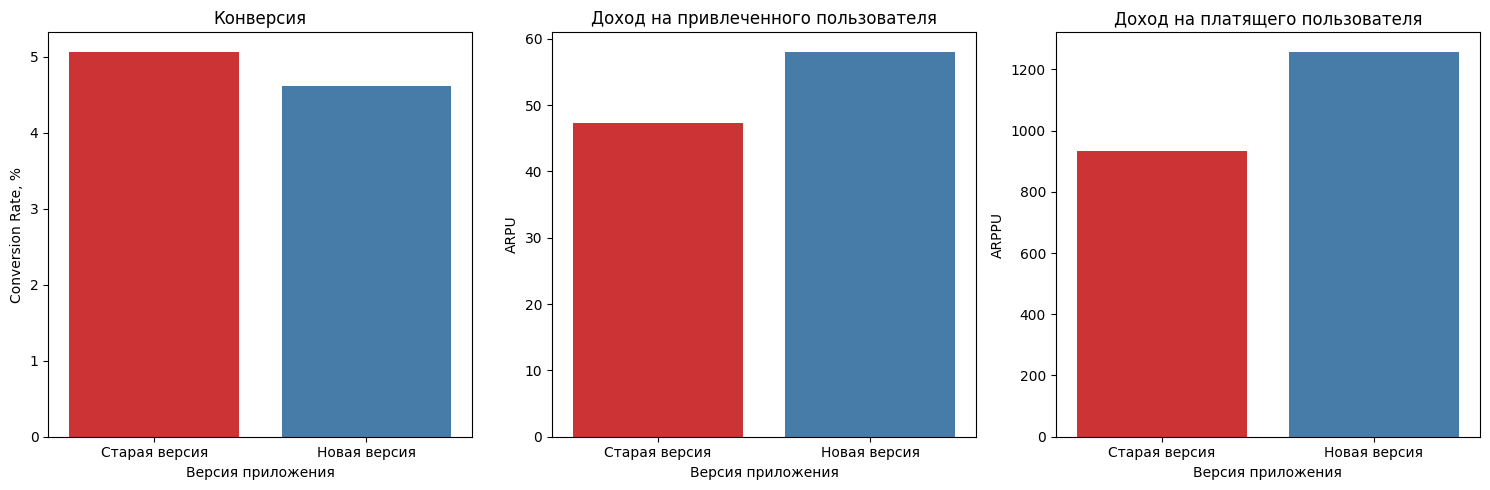

In [41]:
sns.set_palette("bright")
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x=metrics['version'], y=metrics['CR'],palette='Set1')
plt.xlabel('Версия приложения')
plt.ylabel('Conversion Rate, %')
plt.title('Конверсия')

plt.subplot(1, 3, 2)
sns.barplot(x=metrics['version'], y=metrics['ARPU'],palette='Set1')
plt.xlabel('Версия приложения')
plt.ylabel('ARPU')
plt.title('Доход на привлеченного пользователя')

plt.subplot(1, 3, 3)
sns.barplot(x=metrics['version'], y=metrics['ARPPU'],palette='Set1')
plt.xlabel('Версия приложения')
plt.ylabel('ARPPU')
plt.title('Доход на платящего пользователя')
plt.tight_layout()
#plt.savefig('Основные метрики')
plt.show()

Мы посчитали основные метрики, которые могли были посчитать на основании наших данных. Теперь необходимо определиться, что мы будем тестировать, конверсию или доходы. Конверсия в разных версиях приложения отличается примерно на пол процента. А вот доходы как на привлеченного пользователя, так и на платящего более существенно.

Я решил для A/B теста выбрать ARPPU. При при расчете ARPPU учитываются только платящие пользователи, то есть те кто что-то купил. CR, в данном случае не особо удачная метрика для а/б теста. Так как я сказал выше сильных отличий нет. Однако в новой версии CR чуть меньше, но об этом поговорим позже. При Расчете ARPU учитываются все пользователи, но так как CR примерно одинаково, я уверен что результат а/б теста ARPU не будет сильно отличаться от ARPPU. На мой взгляд аналитик должен уметь выбирать именно нужную метрику для а/б теста.

Посмотрим на статистические характеристики. для этого обратимся к датафрейму user_and_client_groups и сделаем из него два датафрейма со старой и новой версией

In [37]:
new_version = user_and_client_groups.query("group=='B' and purchase=='yes'")
old_version = user_and_client_groups.query("group=='A' and purchase=='yes'")

Посмотрим на нормальность распределения данных

Text(0, 0.5, 'Частота')

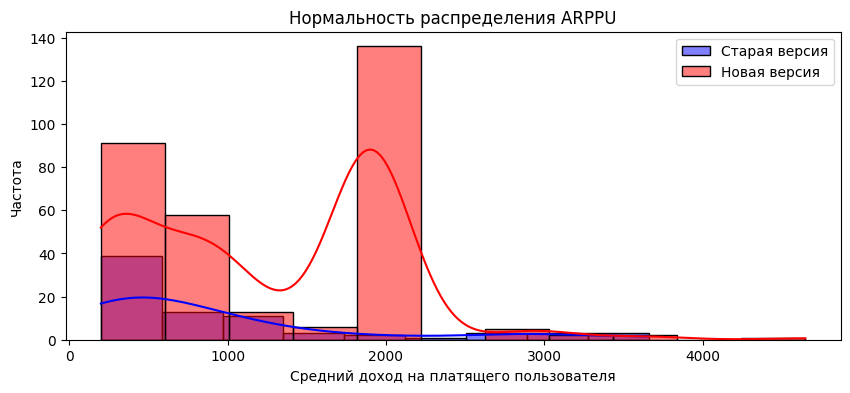

In [44]:
plt.figure(figsize=(10, 4))
sns.histplot(data=old_version, x='revenue', kde=True,color='blue', label='Старая версия')
sns.histplot(data=new_version, x='revenue', kde=True,color='red', label='Новая версия')
plt.legend()
plt.title('Нормальность распределения ARPPU')
plt.xlabel('Средний доход на платящего пользователя')
plt.ylabel('Частота')
#plt.savefig('Нормальность распределения ARPPU.jpeg')

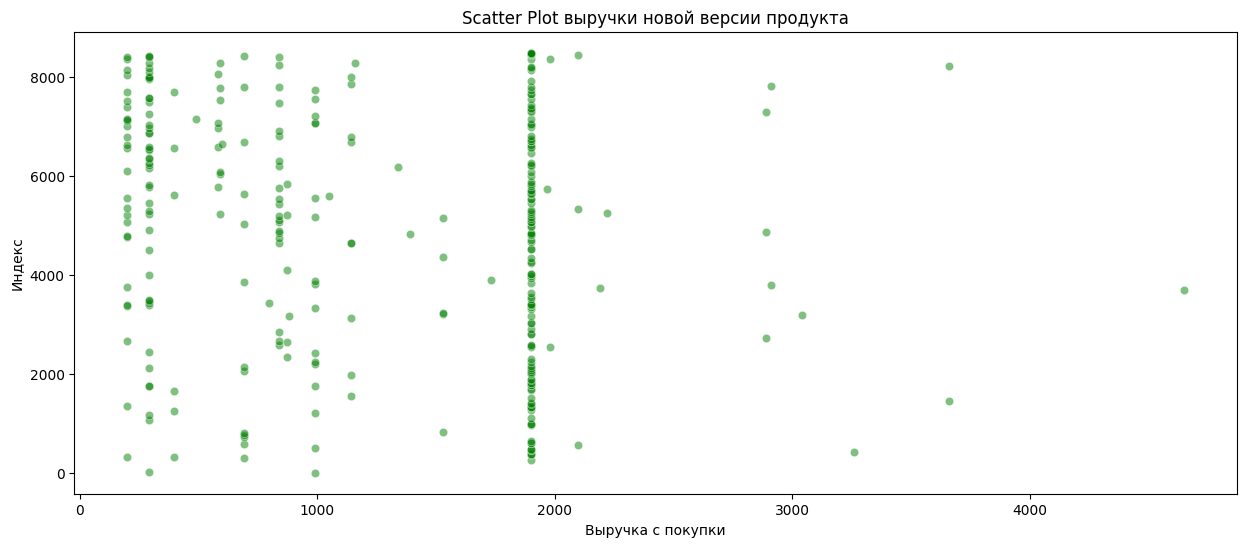

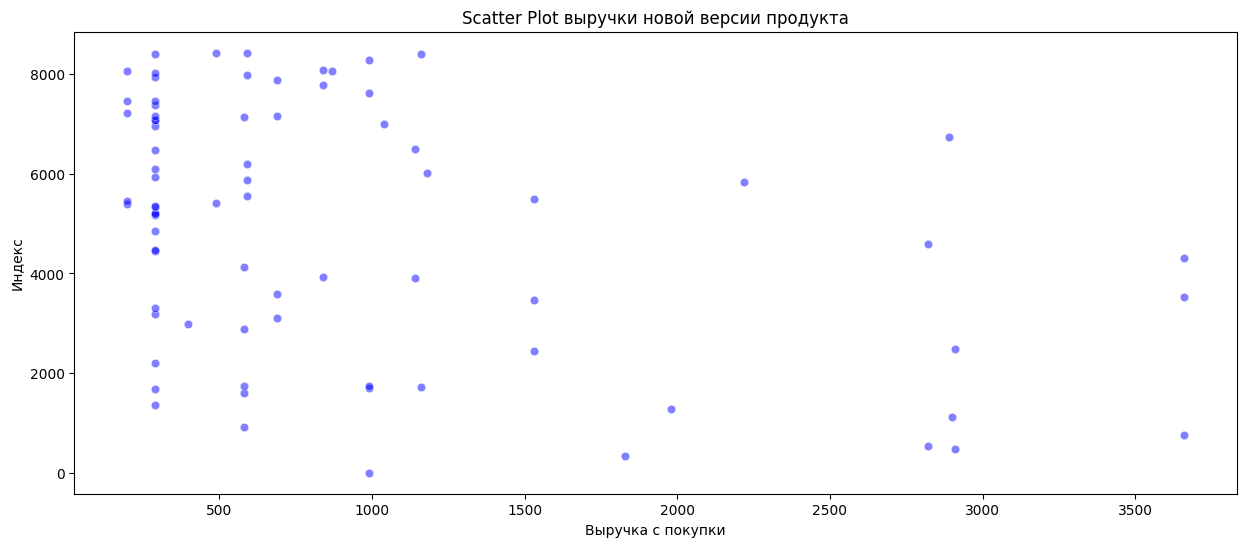

In [48]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x='revenue', y=new_version.index, data=new_version, color='green', alpha=0.5)
plt.xlabel('Выручка с покупки')
plt.ylabel('Индекс')
plt.title('Scatter Plot выручки новой версии продукта')
#plt.savefig('Scatter plotnew.jpeg')
plt.show()

plt.figure(figsize=(15, 6))
sns.scatterplot(x='revenue', y=old_version.index, data=old_version, color='blue', alpha=0.5)
plt.xlabel('Выручка с покупки')
plt.ylabel('Индекс')
plt.title('Scatter Plot выручки новой версии продукта')
#plt.savefig('Scatter plotold.jpeg')
plt.show()


Как видно из графиков выше распределения далеки от нормальных.

Построим боксплот

In [49]:
# Сделаем отдельных датафрейм для боксплота, для красивой визуализации.
df_boxplot = user_and_client_groups.query("purchase=='yes'")
df_boxplot['version'] = df_boxplot['group'].apply(lambda x: 'Старая версия' if x=='A' else 'Новая версия')

C:\Users\mirza\AppData\Local\Temp\ipykernel_44336\655413081.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot['version'] = df_boxplot['group'].apply(lambda x: 'Старая версия' if x=='A' else 'Новая версия')


C:\Users\mirza\AppData\Local\Temp\ipykernel_44336\2047032043.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='version', y='revenue', data=df_boxplot,palette='Set1')


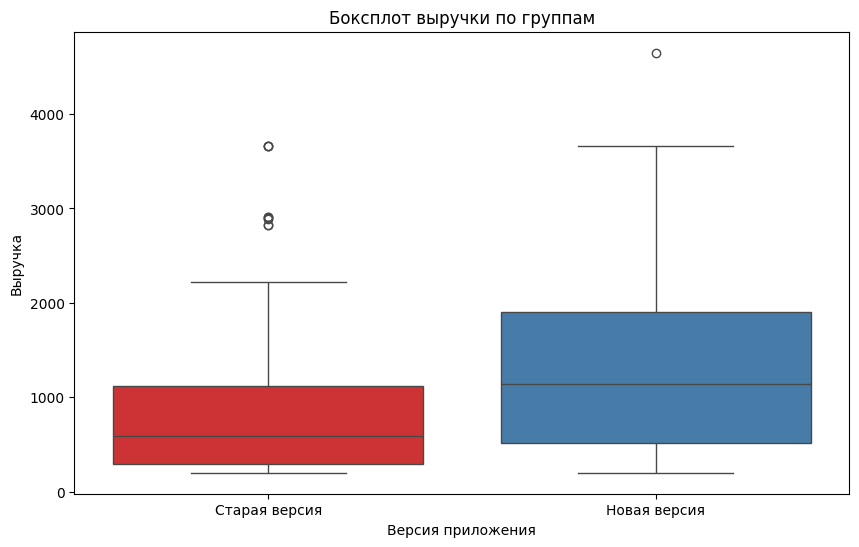

In [51]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='version', y='revenue', data=df_boxplot,palette='Set1')
plt.xlabel('Версия приложения')
plt.ylabel('Выручка')
plt.title('Боксплот выручки по группам')
plt.show()

In [52]:
# Посмотрим статистические характеристики платящих пользователей
statistical_characteristics = df_boxplot.groupby('version').revenue.describe()
statistical_characteristics

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
Новая версия,314.0,1257.878992,790.864254,199.0,511.75,1140.0,1900.00,4650.0
Старая версия,78.0,933.589744,919.932711,199.0,290.00,585.0,1114.75,3660.0


In [53]:
#Проведение теста Левена на гомогенность дисперсий
from scipy.stats import levene
statistic, p_value = levene(old_version['revenue'], new_version['revenue'])
print("Статистика теста Левена:", statistic)
print("p-значение:", p_value)

Статистика теста Левена: 3.075681699981606
p-значение: 0.08025675761347023


In [57]:
# Проведение теста Колмогорова-Смирнова на нормальность распределения данных
from scipy.stats import ks_2samp
statistic, p_value = ks_2samp(old_version['revenue'], new_version['revenue'])
# Вывод результатов теста
print("Статистика теста Колмогорова-Смирнова:", statistic)
print("p-значение:", p_value)

Статистика теста Колмогорова-Смирнова: 0.323942511840601
p-значение: 2.3982639149052183e-06


Как видно выше из тестов на нормальность, наши данные далеки от нормальных. Но однако, исходя из теста Левена, у нас достаточно оснований, чтобы считать, что наши дисперсии гомогенны.

## Выбор теста

Как видно выше у нас отсутствует нормальность распределения данных. Я решил в данном случае применить bootstrap.

Напишем функции для проведения бутстрапа каждой версии приложения, сравним как по медиане, так и по среднему значению.

In [58]:
# Функция для проведения бутстрапа
def bootstrap(data, stat_func, n_iterations=1000):
    bootstrap_results = []
    
    for _ in range(n_iterations):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        result = stat_func(bootstrap_sample)
        bootstrap_results.append(result)
    
    return bootstrap_results

In [59]:
# Проведение бутстрапа для средних значений новой версии приложения:
bootstrap_results_new_mean = bootstrap(new_version['revenue'], np.mean)

# Вывод результатов для новой версии приложения:
print("Среднее значение выборок новой версии приложения:", np.mean(bootstrap_results_new_mean))
print("95% доверительный интервал средних значений новой версии приложения:", np.percentile(bootstrap_results_new_mean, [2.5, 97.5]))

# Проведение бутстрапа для средних значений старой версии приложения:
bootstrap_results_old_mean = bootstrap(old_version['revenue'], np.mean)

# Вывод результатов для старой версии приложения:
print("Среднее значение выборок старой версии приложения:", np.mean(bootstrap_results_old_mean))
print("95% доверительный интервал средних значений старой версии приложения:", np.percentile(bootstrap_results_old_mean, [2.5, 97.5]))

Среднее значение выборок новой версии приложения: 1262.3937754668789
95% доверительный интервал средних значений новой версии приложения: [1174.70940477 1351.57485419]
Среднее значение выборок старой версии приложения: 941.255435897436
95% доверительный интервал средних значений старой версии приложения: [ 747.00897436 1157.93269231]


In [60]:
# Проведение бутстрапа для медианных значений новой версии приложения:
bootstrap_results_new_median = bootstrap(new_version['revenue'], np.median)

# Вывод результатов для новой версии приложения:
print("Медианное значение выборок новой версии приложения:", np.mean(bootstrap_results_new_median))
print("95% доверительный интервал медианных значений новой версии приложения:", np.percentile(bootstrap_results_new_median, [2.5, 97.5]))


# Проведение бутстрапа для медианных значений старой версии приложения:
bootstrap_results_old_median = bootstrap(old_version['revenue'], np.median)

# Вывод результатов для старой версии приложения:
print("Медианные значения выборок старой версии приложения:", np.mean(bootstrap_results_old_median))
print("95% доверительный интервал медианных значений старой версии приложения:", np.percentile(bootstrap_results_old_median, [2.5, 97.5]))

Медианное значение выборок новой версии приложения: 1269.161
95% доверительный интервал медианных значений новой версии приложения: [ 990. 1900.]
Медианные значения выборок старой версии приложения: 589.9235
95% доверительный интервал медианных значений старой версии приложения: [398. 690.]


## Вывод

Как видно выше, у нас ARPU и ARPPU новой версии приложения гораздо выше, чем в старой. Статистический анализ показал, что наши данные по выручке статистически значимо различаются. В связи с этим у нас есть основания полагать, что стоит выкатить новую версию приложения. Конверсия в покупку в новой версии приложения получилась чуть меньше. Возможно это связано с тем, что минимальная сумма покупки увеличилась или еще с чем-то, это необходимо выяснить разработчикам, возможно просто так получилось во время эксперимента. Еше стоит обратить внимание на ту аномалию, почему пользователи которые не посещали сайт, совершили оплату, так как в новой версии приложения их гораздо больше.